# msticpy - Polling Detection

When analysing network traffic on a host to identify unusual activity, it's common that there is a large amount of traffic generated. Much of this traffic is automatically generated and highly periodic.[1] By filtering out this highly periodic polling traffic it leaves the analyst with less traffic and it is more likely to be generated by humans.

It's this human generated traffic that is likely to contain any unusual behaviour that would be of interest to an analyst. This notebook demonstrates a method of detecting events that occur with a strong periodicity, *i.e an email client contacting an SMTP server every 60 seconds to check for new mail*. In this example there would be a strong periodicity at around 60 seconds.

This model requires the **scipy** library which can be installed with

`pip install --upgrade msticpy[ml]`

Alternatively if you only plan on using the polling detection submodule from the analysis module then you can just install scipy

`pip install scipy`

In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


### Setup

In [84]:
from collections import Counter
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
from msticpy.analysis.polling_detection import PeriodogramPollingDetector

In [87]:
sns.set_style("whitegrid")

plt.rcParams['axes.formatter.useoffset'] = False

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

InteractiveShell.ast_node_interactivity = "last_expr"

### Analysis

For this analysis we have some NetFlow data and we wish to determine which edges are highly periodic and can be removed prior to analysis. An edge in this case is a source IP --> destination IP address pair.

In [4]:
df = pd.read_csv(
    "docs/notebooks/data/az_net_flows.csv",
    parse_dates=["FlowEndTime"]
)

To create the edges I'm going to separate the two IP addresses with a double colon 

i.e. 10.0.3.5::65.55.44.109 is a connection between the source address 10.0.3.5 and destination address 65.55.44.109

In [27]:
df["edges"] = df["VMIPAddress"] + "::" + df["AllExtIPs"]

In [82]:
def time_of_day_plot(edge, axes):
    edge_df = df[df["edges"] == edge]

    five_min_counts = (
        edge_df[["TenantId", "FlowEndTime"]].set_index("FlowEndTime")
            .resample("5T")
            .count()
            .rename({"TenantId": "count"}, axis=1)
            .reset_index()
    )

    five_min_counts["FlowEndTime"] = five_min_counts["FlowEndTime"].apply(lambda x: x.replace(day=1))

    five_min_counts["SecondsOfDay"] = five_min_counts["FlowEndTime"].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

    five_min_counts["SecondsOfDayRescaled"] = five_min_counts["SecondsOfDay"] / 86400

    axes.set_theta_zero_location("N")
    axes.set_theta_direction(-1)

    pal = sns.husl_palette(2)

    axes.plot(five_min_counts["SecondsOfDayRescaled"] * 2 * np.pi, five_min_counts["count"], alpha=0.35, color="grey", linewidth=3)
    axes.scatter(five_min_counts["SecondsOfDayRescaled"] * 2 * np.pi, five_min_counts["count"], facecolor=pal[1], s=50, alpha=0.6)
    axes.set_xticks(np.linspace(0, max(axes.get_xticks()) + 0.5, 24), np.arange(0, 24))

    axes.set_yticks([])
    axes.set_title(edge)

    axes.grid(False)


In [91]:
df["timestamp"] = df["FlowEndTime"].apply(datetime.timestamp).astype("int64")

In [94]:
def connections_time_series_plot(edge, axes):
    edge_df = df[df["edges"] == edge]

    counter = Counter(edge_df["timestamp"])

    x = np.arange(edge_df["timestamp"].min(), edge_df["timestamp"].max())

    x_date = pd.to_datetime(x, unit="s")

    pal = sns.husl_palette(2)

    axes.plot(x_date, [counter[i] for i in x], "o", color=pal[0], alpha=0.5)
    axes.plot(x_date, [counter[i] for i in x], alpha=0.35, color="grey", linewidth=3)

    axes.grid(False)

    axes.set_title(edge)

    sns.despine(right=True, top=True)

lets take a look at the connection times on some of the edges. 

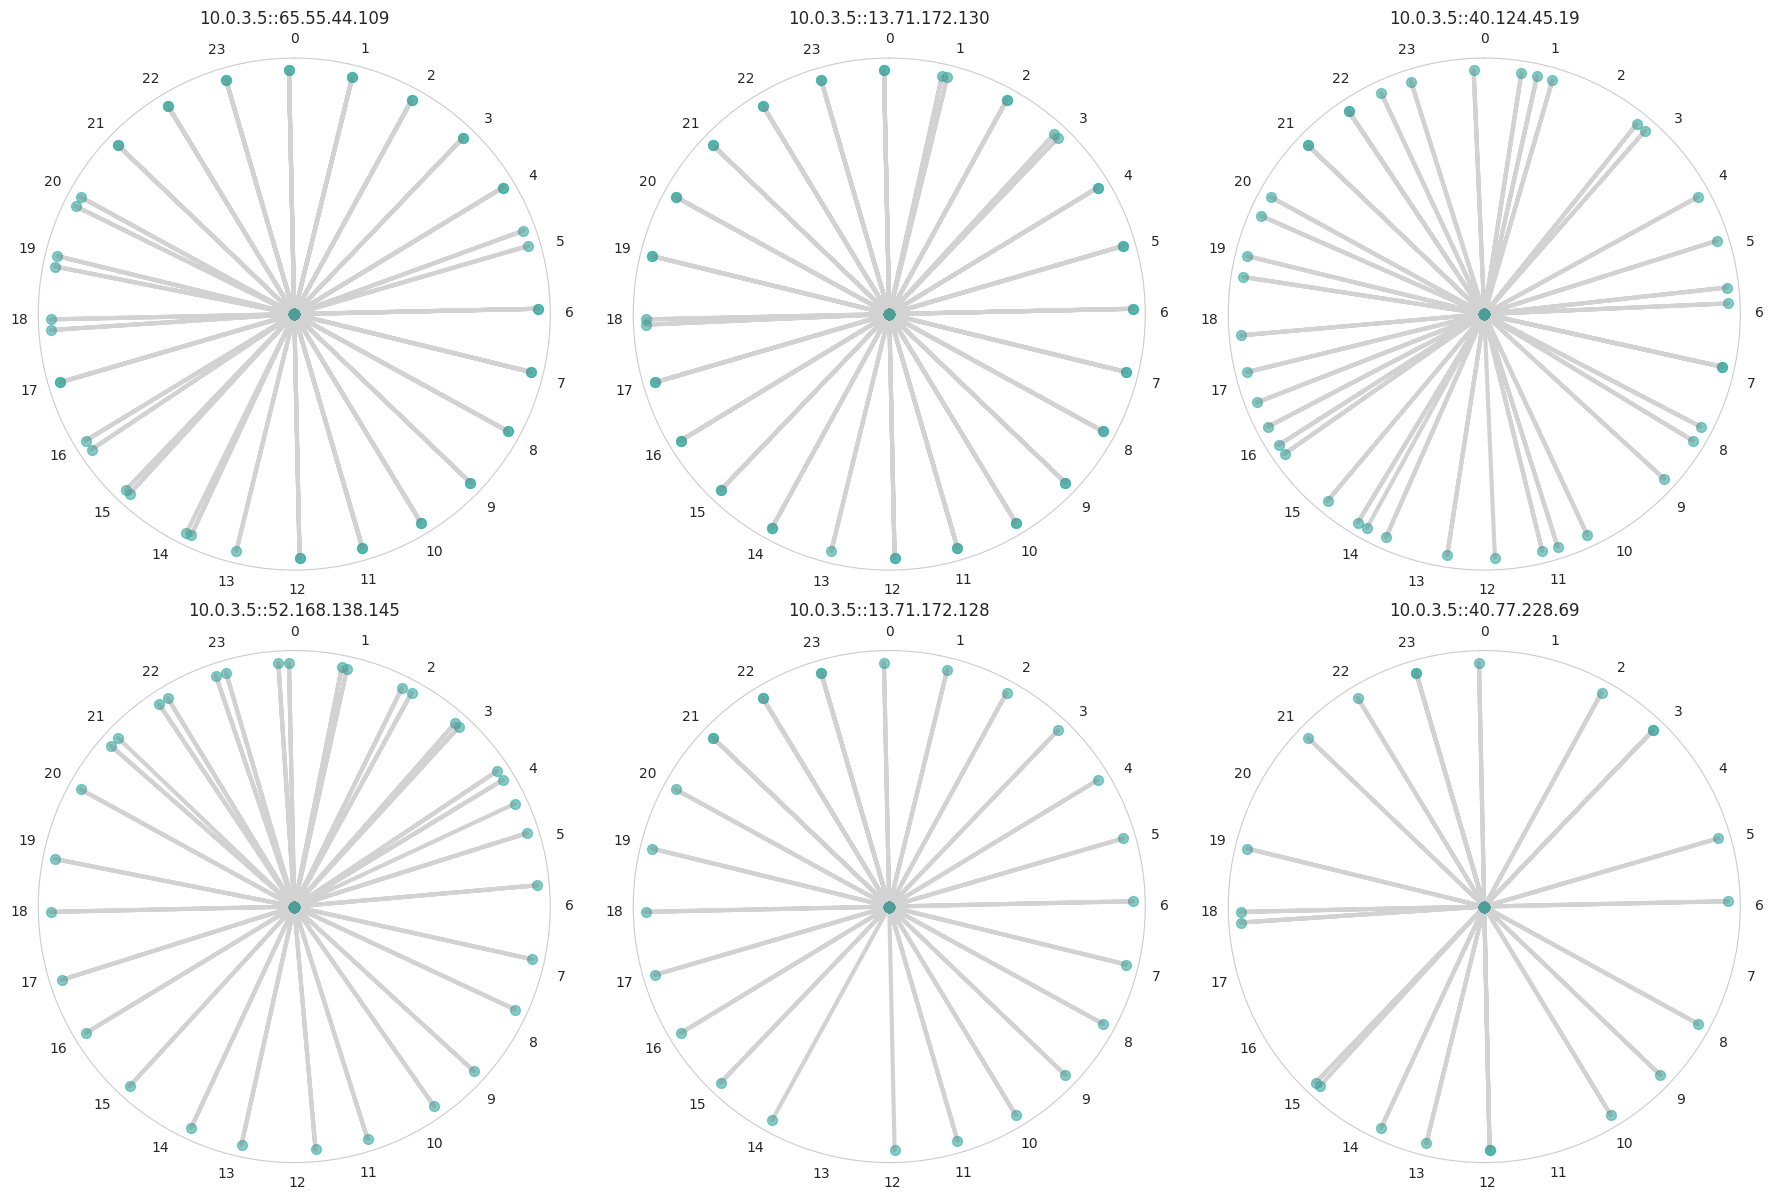

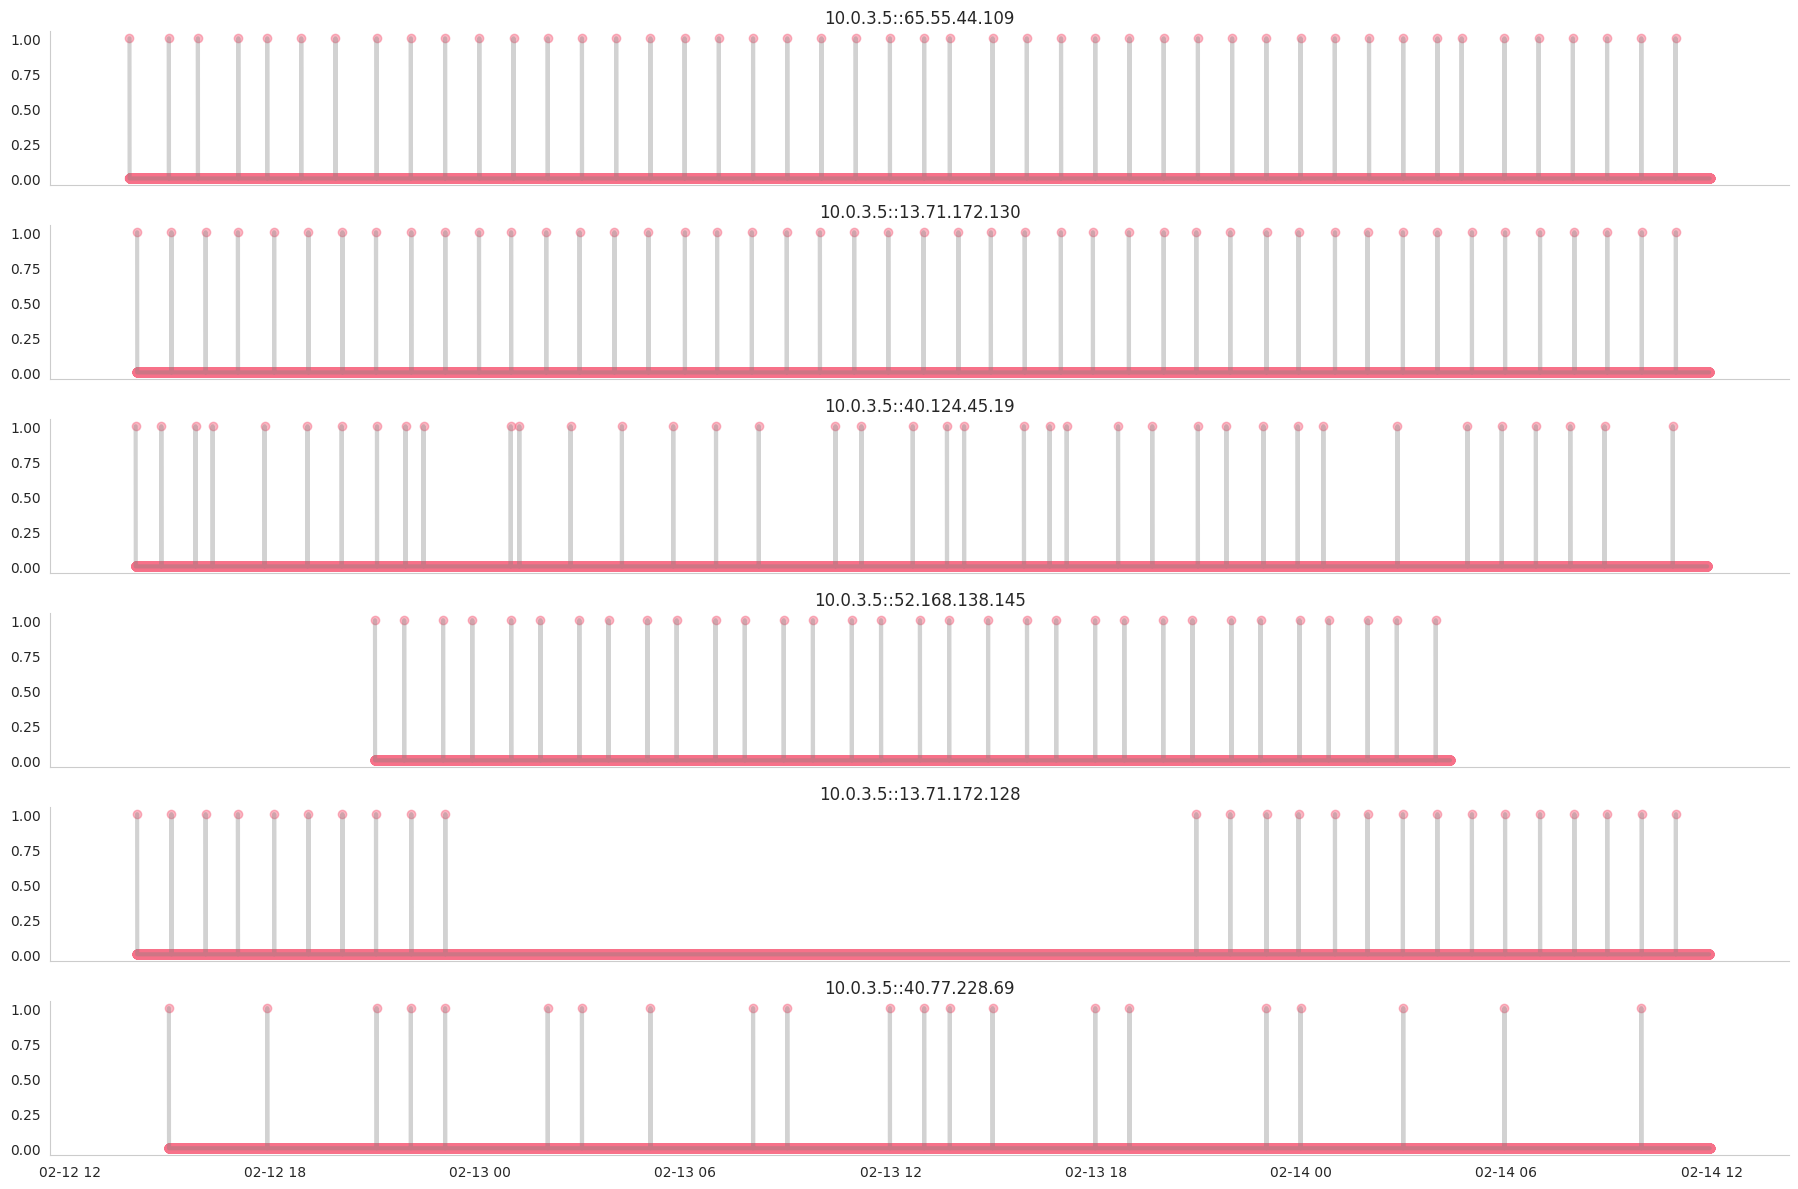

In [99]:
busiest_edges = df["edges"].value_counts()

f1, ax1 = plt.subplots(subplot_kw={"projection": "polar"}, ncols=3, nrows=2, figsize=(18, 12))
f2, ax2 = plt.subplots(ncols=1, nrows=6, figsize=(18, 12), sharex=True)

for i in range(6):
    ax1 = ax1.flatten()
    ax2 = ax2.flatten()

    time_of_day_plot(busiest_edges.index[i], ax1[i])
    connections_time_series_plot(busiest_edges.index[i], ax2[i])

f1.tight_layout()
f2.tight_layout()
plt.show()

Looking at the plots above, each edge looks quite strongly periodic however this is test data and on real world datasets it is likely to be a lot noisier and harder to tell. Also even if it was easy to identify automated edges visually, the volume of edges is likely to be large enough that manual classification wouldn't be feasible.

A possible solution to this is using a statistical model to identify edges that are more likely to be polling edges and either manually inspect the edges returned by the model. Depending on the consequence of false positives a threshold could be set for the model and anything below that threshold would be considered a polling edge.

The model available in msticpy estimates the periodogram of the for the edge connections and tests how strong the dominant frequency is relative to all of the other frequencies. The larger the peak relative to all of the other frequencies, the lower the $p$-value that is returned. 

The null hypothesis for this test is that the time series is white noise and contains no periodic component. We're not following the NHST framework to the letter so we'll be using the $p$-values as scores and the lower the score the more we think that this could be a periodic edge.

*Appendix 1 has the equations used to calculate the scores mentioned above*

Now lets apply the model to each edge in our dataset and investigate the scores

In [105]:
per = PeriodogramPollingDetector()

scores = df.groupby("edges").apply(lambda x: per.detect_polling(x["timestamp"], df["timestamp"].min(), df["timestamp"].max()))

In [107]:
scores = scores.sort_values()

We now have a list of edges and their associated scores from the model. Lets take a look at the 3 lowest scoring edges and 3 edges that have high p values but are less than 1.

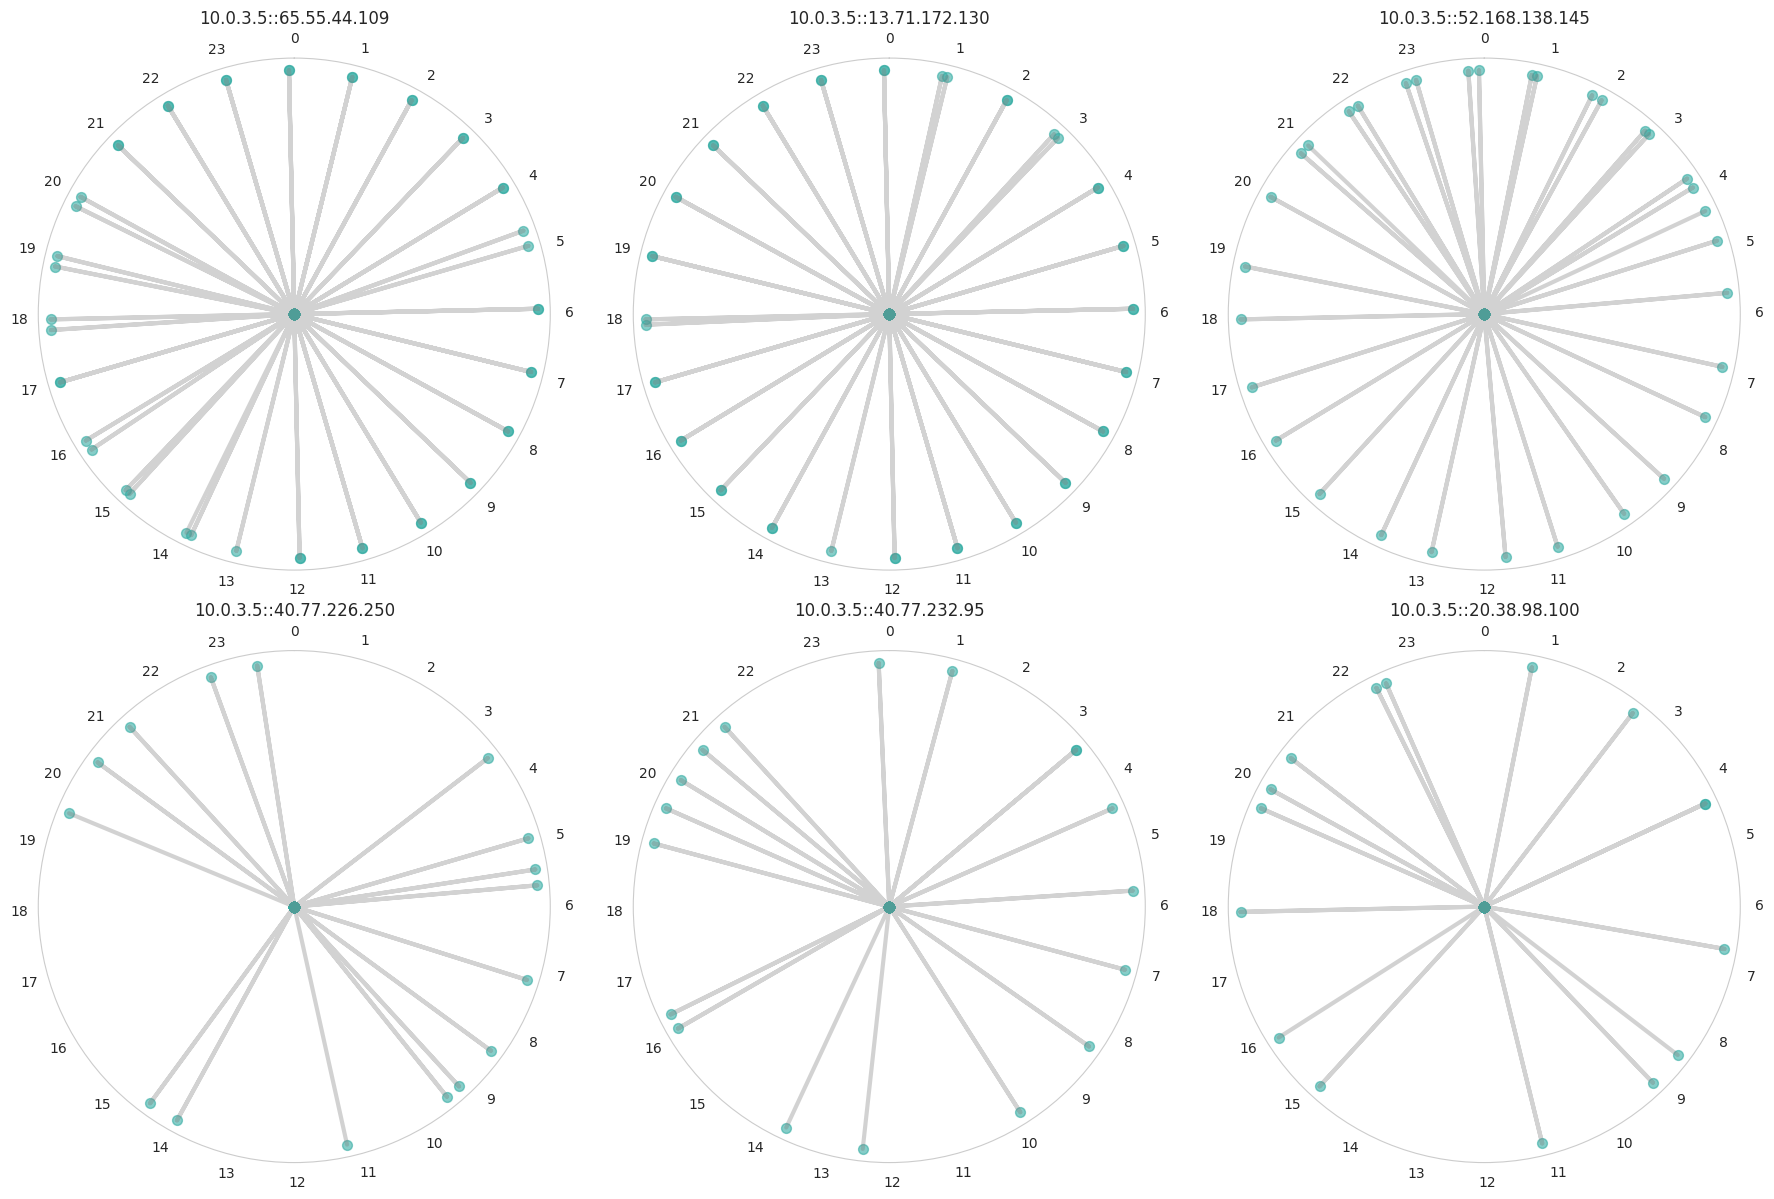

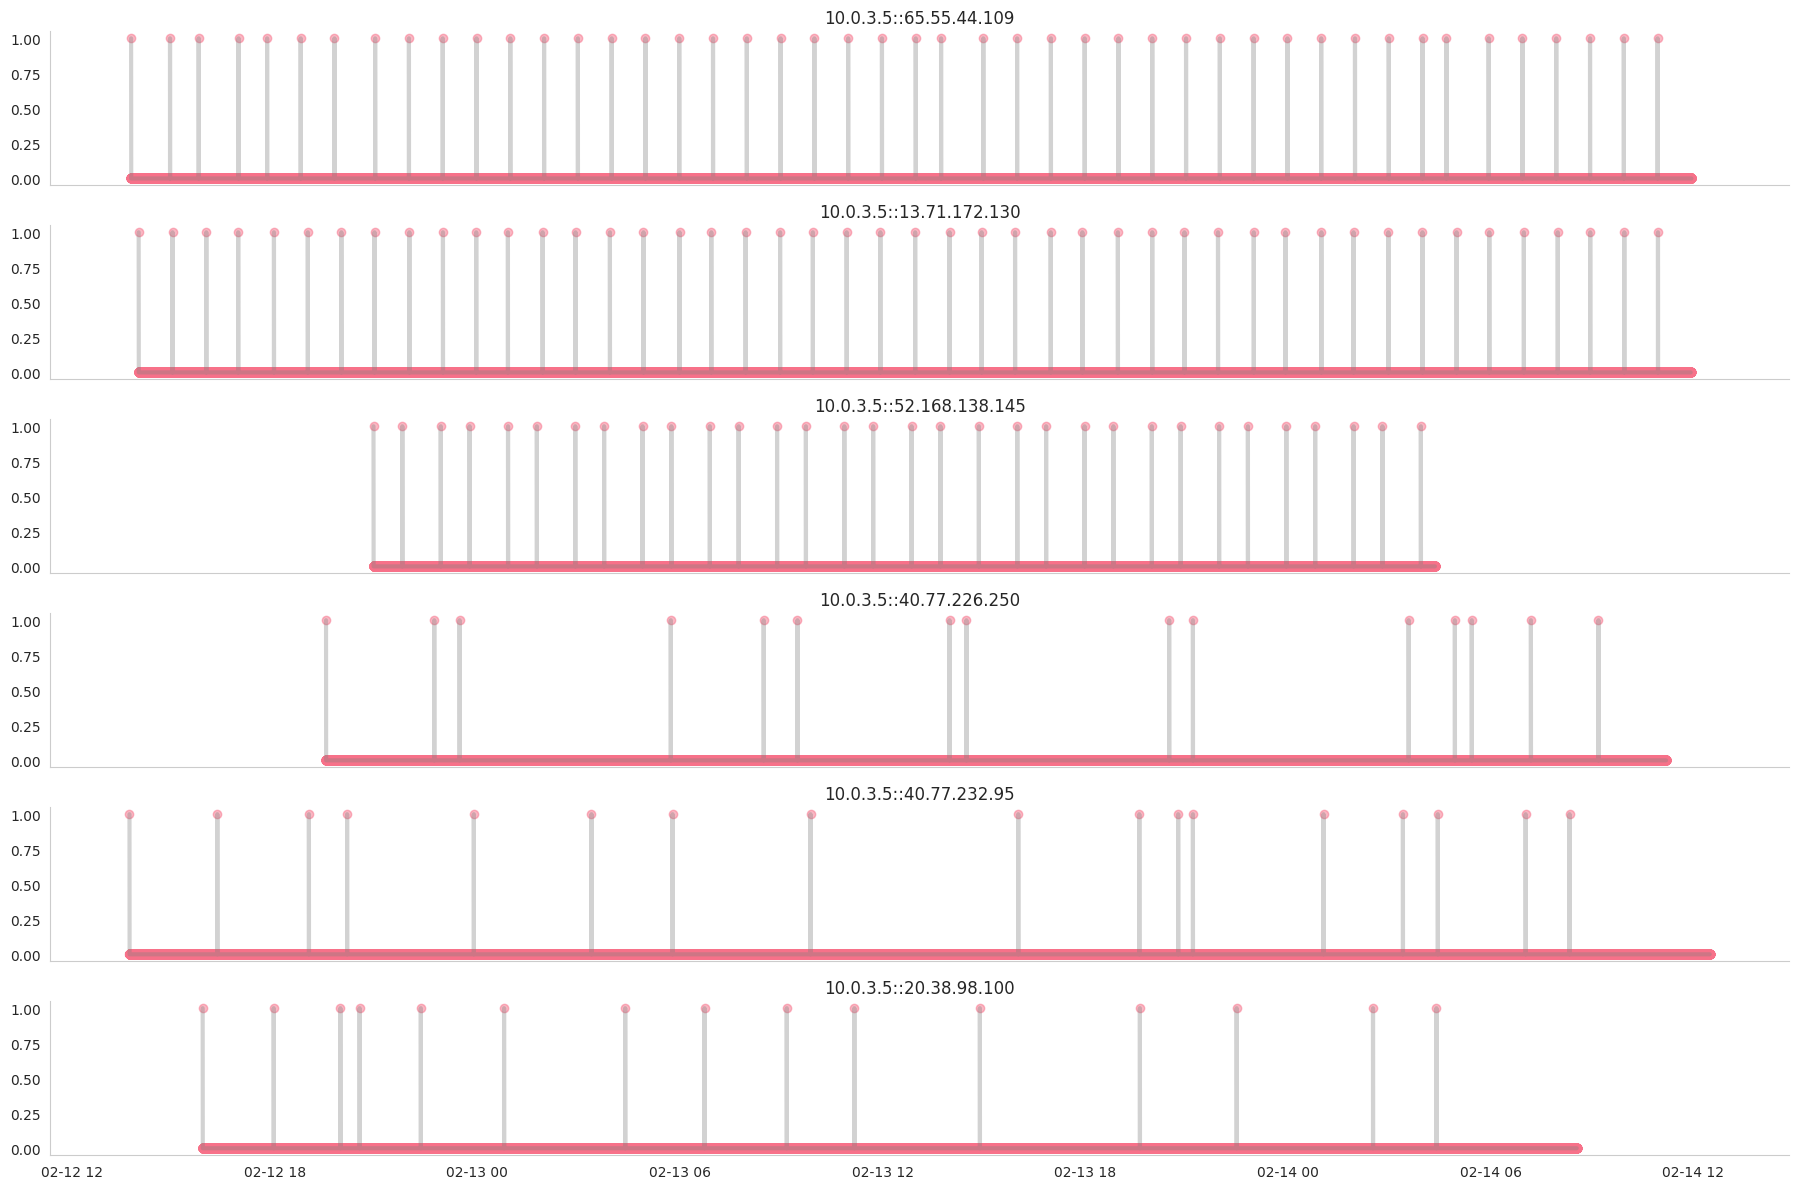

In [122]:
busiest_edges = pd.concat([scores.head(3), scores.tail(75)[:3]])

f1, ax1 = plt.subplots(subplot_kw={"projection": "polar"}, ncols=3, nrows=2, figsize=(18, 12))
f2, ax2 = plt.subplots(ncols=1, nrows=6, figsize=(18, 12), sharex=True)

for i in range(6):
    ax1 = ax1.flatten()
    ax2 = ax2.flatten()

    time_of_day_plot(busiest_edges.index[i], ax1[i])
    connections_time_series_plot(busiest_edges.index[i], ax2[i])

f1.tight_layout()
f2.tight_layout()
plt.show()

## Appendix

#### Periodogram

The periodogram estimate is as follows 

$$\Large \left. S_{XY}(f) = \left\lvert \sum_{t = 1}^{T} (dN_{XY}(t) - N_{XY}(T)/T) e^{i2\pi ft} \right\rvert^{2} \middle/ T \right.$$

$dN_{XY}(t)$ is either $1$ or $0$ denoting the presence or absence of at least one connection between IP $X$ and IP $Y$ between time $t$ and $t - 1$ 

$N_{XY}(T)/T$ is the estimated mean rate of the process up to time $T$

#### Fishers G test

$$\Large g_{XY} = \left. \underset{f \in \mathcal{F}}{\max} S_{XY}(f) \middle/ \sum_{f^{\prime} \in \mathcal{F}} S_{XY}(f^{\prime}) \right.$$

## References

[1] Heard, N. A. and Rubin-Delanchy, P. T. G. and Lawson, D. J. (2014) Filtering automated polling traffic in computer network flow data. In proceedings of IEEE Joint Intelligence and Security Informatics Conference 2014